In [24]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [25]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [26]:
path = Config.data_path()/'carvana'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/carvana')

In [27]:
 #! kaggle competitions download -c carvana-image-masking-challenge -p {path}

In [28]:
img_path = path/'train_hq'
mask_path = path/'train_masks'

fnames = get_image_files(img_path)
labl_names = get_image_files(mask_path)



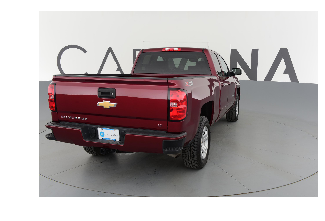

In [29]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))


In [30]:
get_y_fn = lambda x: mask_path/f'{x.stem}_mask.gif'

In [31]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegItemListCustom(ImageImageList):
    _label_cls = SegLabelListCustom


In [32]:
codes = np.array([0, 1])
src_size = np.array(img.shape[1:])
bs = 4
size = [320,480]

src = (SegItemListCustom.from_folder(img_path)
       .split_by_rand_pct(0.2)
       .label_from_func(get_y_fn, classes=codes))

In [33]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

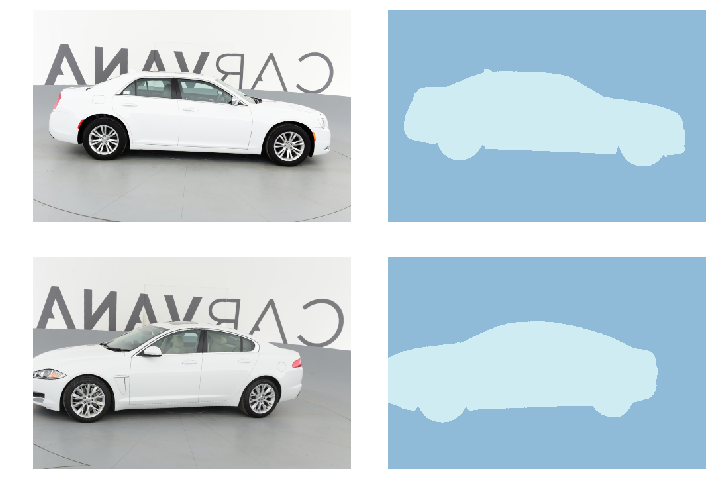

In [34]:
data.show_batch(2, figsize=(10,7))

In [35]:
def my_acc(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()



In [36]:
learn = unet_learner(data, models.resnet34, metrics = [my_acc, dice], wd=1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


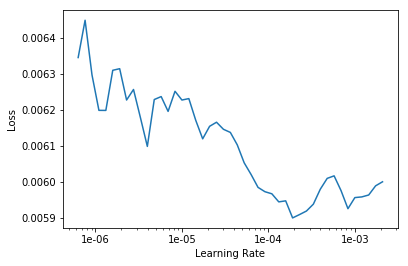

In [123]:
lr_find(learn)
learn.recorder.plot()

In [37]:
lr=3e-4

In [65]:
learn.tofp16().fit_one_cycle(3, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,my_acc,time
0,0.008465,0.007487,0.997055,10:42
1,0.007697,0.007361,0.997195,10:53
2,0.006366,0.005412,0.997840,10:51


In [134]:
learn.save('stage-1')


In [39]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (4071 items)
x: SegItemListCustom
Image (3, 320, 480),Image (3, 320, 480),Image (3, 320, 480),Image (3, 320, 480),Image (3, 320, 480)
y: SegLabelListCustom
ImageSegment (1, 320, 480),ImageSegment (1, 320, 480),ImageSegment (1, 320, 480),ImageSegment (1, 320, 480),ImageSegment (1, 320, 480)
Path: /home/jupyter/.fastai/data/carvana/train_hq;

Valid: LabelList (1017 items)
x: SegItemListCustom
Image (3, 320, 480),Image (3, 320, 480),Image (3, 320, 480),Image (3, 320, 480),Image (3, 320, 480)
y: SegLabelListCustom
ImageSegment (1, 320, 480),ImageSegment (1, 320, 480),ImageSegment (1, 320, 480),ImageSegment (1, 320, 480),ImageSegment (1, 320, 480)
Path: /home/jupyter/.fastai/data/carvana/train_hq;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

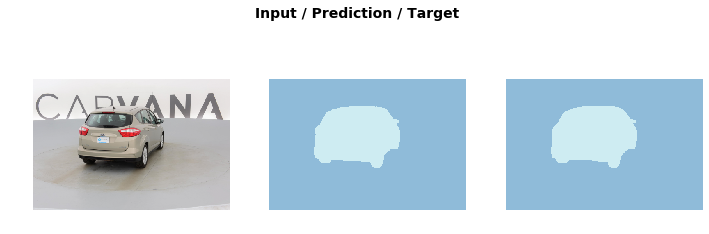

In [40]:
learn.show_results(rows=1)

In [41]:
learn.unfreeze()


In [42]:
lrs = slice(lr/400,lr/4)

In [44]:
learn.fit_one_cycle(1, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,my_acc,dice,time
0,0.005448,0.005062,0.997957,0.995132,11:11


In [54]:
learn.save('stage-2');


In [155]:
img = open_image('car2.jpg'); img
out,_,_ = learn.predict(img)

In [95]:
import cv2 as cv

In [156]:
out = np.array(out.data)
out = out.squeeze().astype('uint8')

In [157]:
car = cv.imread('car2.jpg')
car = cv.resize(car, ((480, 320)))
out = cv.merge((out, out, out))

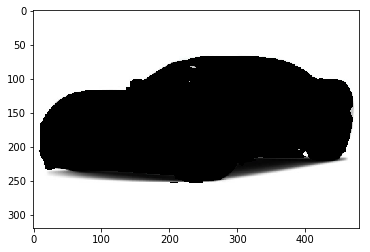

In [166]:
plt.imshow(cv.multiply(1-out,car))

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


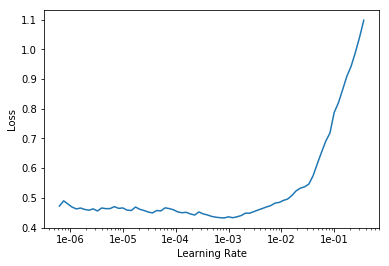

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.366140,0.339497,0.908682
2,0.333278,0.304011,0.916702
3,0.326025,0.305404,0.919941
4,0.336885,0.321342,0.910933
5,0.326935,0.305589,0.919401
6,0.347779,0.333608,0.908895
7,0.328334,0.352358,0.905482
8,0.327277,0.387525,0.912187
9,0.291777,0.293065,0.918046
10,0.228348,0.257859,0.929750


In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.225999,0.254650,0.930782
2,0.216341,0.256007,0.930751
3,0.209800,0.255649,0.930709
4,0.203509,0.252857,0.931682
5,0.202308,0.258498,0.931308
6,0.200796,0.257311,0.931915
7,0.204560,0.251486,0.933218
8,0.192893,0.254977,0.932786
9,0.189505,0.258091,0.932555
10,0.190156,0.256064,0.933315


In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

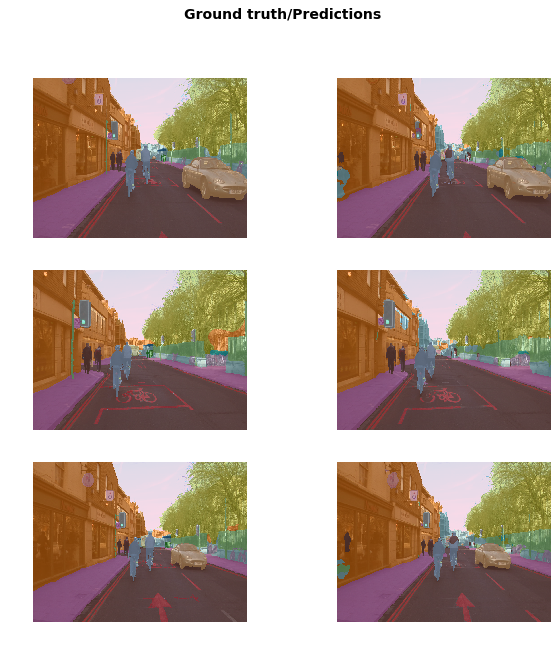

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin